In [1]:
import os
import cv2
import pydicom
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt 
import random
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error
from tensorflow.keras import Model
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
from keras.layers import LSTM
from tensorflow.keras.optimizers import Nadam
import seaborn as sns
from PIL import Image

def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything(42)

2024-06-06 21:31:27.391070: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-06 21:31:27.391195: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-06 21:31:27.524449: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [3]:
import keras
print(keras.__version__)

3.2.1


In [4]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [5]:
base_path = '/kaggle/input/osic-pulmonary-fibrosis-progression/'
train = pd.read_csv(base_path + 'train.csv')

# Linear Decay (based on EfficientNets)

In [6]:
def get_tab(df):
    vector = [(df.Age.values[0] - 30) / 30] 
    
    if df.Sex.values[0] == 'male':
        vector.append(0)
    else:
        vector.append(1)
    
    if df.SmokingStatus.values[0] == 'Never smoked':
        vector.extend([0,0])
    elif df.SmokingStatus.values[0] == 'Ex-smoker':
        vector.extend([1,1])
    elif df.SmokingStatus.values[0] == 'Currently smokes':
        vector.extend([0,1])
    else:
        vector.extend([1,0])
    return np.array(vector) 

In [7]:
A = {} 
TAB = {} 
P = [] 
for i, p in tqdm(enumerate(train.Patient.unique())):
    sub = train.loc[train.Patient == p, :] 
    fvc = sub.FVC.values
    weeks = sub.Weeks.values
    c = np.vstack([weeks, np.ones(len(weeks))]).T
    a, b = np.linalg.lstsq(c, fvc)[0]
    
    A[p] = a
    TAB[p] = get_tab(sub)
    P.append(p)

0it [00:00, ?it/s]

/tmp/ipykernel_25/3152059254.py:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  a, b = np.linalg.lstsq(c, fvc)[0]


## CNN for coeff prediction

In [8]:
def get_img(path):
    d = pydicom.dcmread(path)
    return cv2.resize(d.pixel_array / 2**11, (300, 300))

In [9]:
from tensorflow.keras.utils import Sequence

class IGenerator(Sequence):
    BAD_ID = ['ID00011637202177653955184', 'ID00052637202186188008618']
    def __init__(self, keys, a, tab, batch_size=32):
        self.keys = [k for k in keys if k not in self.BAD_ID]
        self.a = a
        self.tab = tab
        self.batch_size = batch_size
        
        self.train_data = {}
        for p in train.Patient.values:
            self.train_data[p] = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/')
    
    def __len__(self):
        return 1000
    
    def __getitem__(self, idx):
        x = []
        a, tab = [], [] 
        keys = np.random.choice(self.keys, size = self.batch_size)
        for k in keys:
            try:
                #/kaggle/input/osic-pulmonary-fibrosis-progression/train
                i = np.random.choice(self.train_data[k], size=1)[0]
                img = get_img(f'/kaggle/input/osic-pulmonary-fibrosis-progression/train/{k}/{i}')
                x.append(img)
                a.append(self.a[k])
                tab.append(self.tab[k])
            except:
                print(k, i)
       
        x,a,tab = np.array(x), np.array(a), np.array(tab)
        x = np.expand_dims(x, axis=-1)
        return [x, tab] , a

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling2D, Concatenate, Dropout, GRU, Reshape, GaussianNoise, Attention, Flatten, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.applications import efficientnet_v2

# Function to get the EfficientNetV2 model
def get_efficientnetv2(model, shape):
    models_dict = {
        'v2b0': efficientnet_v2.EfficientNetV2B0(input_shape=shape, weights=None, include_top=False),
        'v2b1': efficientnet_v2.EfficientNetV2B1(input_shape=shape, weights=None, include_top=False),
        'v2b2': efficientnet_v2.EfficientNetV2B2(input_shape=shape, weights=None, include_top=False),
        'v2b3': efficientnet_v2.EfficientNetV2B3(input_shape=shape, weights=None, include_top=False),
        'v2s': efficientnet_v2.EfficientNetV2S(input_shape=shape, weights=None, include_top=False),
        'v2m': efficientnet_v2.EfficientNetV2M(input_shape=shape, weights=None, include_top=False),
        'v2l': efficientnet_v2.EfficientNetV2L(input_shape=shape, weights=None, include_top=False)
    }
    return models_dict[model]

def build_model(shape=(300, 300, 1), model_class=None):
    inp = Input(shape=shape)
    base = get_efficientnetv2(model_class, shape)
    x = base(inp)
    print(x.shape)
    x = GlobalAveragePooling2D()(x)
    inp2 = Input(shape=(4,))
    x2 = tf.keras.layers.GaussianNoise(0.2)(inp2)
    x2 = tf.keras.layers.Reshape((4,1),input_shape=(4,))(x2)
    x2 = tf.keras.layers.GRU(128, return_sequences=True)(x2)
    #print(x2.shape)
    x2 = tf.keras.layers.Reshape((512,),input_shape=(4,128,))(x2)
    x = Concatenate()([x, x2]) 
    x = Dropout(0.3)(x) 
    x = Dense(1)(x)
    model = Model(inputs=(inp, inp2), outputs=x)
    #/kaggle/input/effnetv2/keras/nv2s/1/efficientnetv2s_70 .keras
    weights = [w for w in os.listdir('/kaggle/input/effnetv2/keras/nv2s/1//') if model_class in w][0]
    model.load_weights('/kaggle/input/effnetv2/keras/nv2s/1//' + weights)
    print('Model Loaded')
    return model

model_classes = ['v2s'] #['v2b0','v2b1','v2b2','v2b3',v2s','v2m','v2l']
models = [build_model(shape=(300, 300, 1), model_class=m) for m in model_classes]
print('Number of models: ' + str(len(models)))

(None, 10, 10, 1280)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model Loaded
Number of models: 1


In [11]:
from sklearn.model_selection import train_test_split 

tr_p, vl_p = train_test_split(P,
                              shuffle=True,
                              train_size= 0.8)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


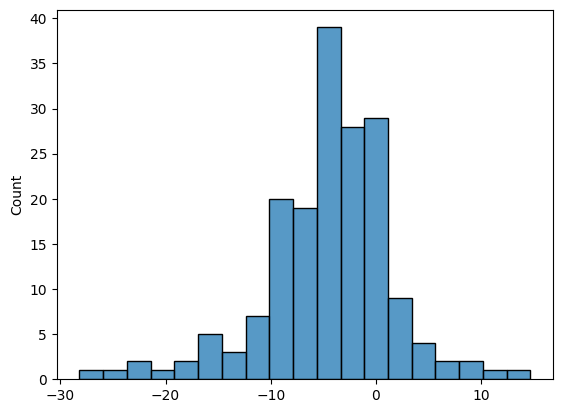

In [12]:
sns.histplot(list(A.values()));

In [13]:
def score(fvc_true, fvc_pred, sigma):
    sigma_clip = np.maximum(sigma, 70) # changed from 70, trie 66.7 too
    delta = np.abs(fvc_true - fvc_pred)
    delta = np.minimum(delta, 1000)
    sq2 = np.sqrt(2)
    metric = (delta / sigma_clip)*sq2 + np.log(sigma_clip* sq2)
    return np.mean(metric)

In [14]:
subs = []
for model in models:
    metric = []
    for q in tqdm(range(1, 10)):
        m = []
        for p in vl_p:
            x = [] 
            tab = [] 
            # Bad-ID there is no record for such patients
            if p in ['ID00011637202177653955184', 'ID00052637202186188008618']:
                continue

            ldir = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/')
            for i in ldir:
                if int(i[:-4]) / len(ldir) < 0.8 and int(i[:-4]) / len(ldir) > 0.15:
                    x.append(get_img(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/{i}')) 
                    tab.append(get_tab(train.loc[train.Patient == p, :])) 
            if len(x) < 1:
                continue
            tab = np.array(tab) 

            x = np.expand_dims(x, axis=-1) 
            _a = model.predict([x, tab]) 
            a = np.quantile(_a, q / 10)

            percent_true = train.Percent.values[train.Patient == p]
            fvc_true = train.FVC.values[train.Patient == p]
            weeks_true = train.Weeks.values[train.Patient == p]

            fvc = a * (weeks_true - weeks_true[0]) + fvc_true[0]
            percent = percent_true[0] - a * abs(weeks_true - weeks_true[0])
            m.append(score(fvc_true, fvc, percent))
        print(np.mean(m))
        metric.append(np.mean(m))

    q = (np.argmin(metric) + 1)/ 10

    sub = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/sample_submission.csv') 
    test = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv') 
    A_test, B_test, P_test,W, FVC= {}, {}, {},{},{} 
    STD, WEEK = {}, {} 
    for p in test.Patient.unique():
        x = [] 
        tab = [] 
        ldir = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/test/{p}/')
        for i in ldir:
            if int(i[:-4]) / len(ldir) < 0.8 and int(i[:-4]) / len(ldir) > 0.15:
                x.append(get_img(f'../input/osic-pulmonary-fibrosis-progression/test/{p}/{i}')) 
                tab.append(get_tab(test.loc[test.Patient == p, :])) 
        if len(x) <= 1:
            continue
        tab = np.array(tab) 

        x = np.expand_dims(x, axis=-1) 
        _a = model.predict([x, tab]) 
        a = np.quantile(_a, q)
        A_test[p] = a
        B_test[p] = test.FVC.values[test.Patient == p] - a*test.Weeks.values[test.Patient == p]
        P_test[p] = test.Percent.values[test.Patient == p] 
        WEEK[p] = test.Weeks.values[test.Patient == p]

    for k in sub.Patient_Week.values:
        p, w = k.split('_')
        w = int(w) 

        fvc = A_test[p] * w + B_test[p]
        sub.loc[sub.Patient_Week == k, 'FVC'] = fvc
        sub.loc[sub.Patient_Week == k, 'Confidence'] = (
            P_test[p] - A_test[p] * abs(WEEK[p] - w) 
    ) 

    _sub = sub[["Patient_Week","FVC","Confidence"]].copy()
    subs.append(_sub)

  0%|          | 0/9 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 362ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 378ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 258ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 557ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 437ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 290ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
7/7 ━━━━━━━━━━━

/tmp/ipykernel_25/2037700604.py:67: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3095.61552248]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sub.loc[sub.Patient_Week == k, 'FVC'] = fvc
/tmp/ipykernel_25/2037700604.py:68: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[145.80237755]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sub.loc[sub.Patient_Week == k, 'Confidence'] = (


## Averaging Predictions

In [15]:
N = len(subs)
sub = subs[0].copy() # ref
sub["FVC"] = 0
sub["Confidence"] = 0
for i in range(N):
    sub["FVC"] += subs[0]["FVC"] * (1/N)
    sub["Confidence"] += subs[0]["Confidence"] * (1/N)

In [16]:
sub.head(10)

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,3095.615522,145.802378
1,ID00421637202311550012437_-12,2851.335869,194.381160
2,ID00422637202311677017371_-12,2005.632935,152.305428
3,ID00423637202312137826377_-12,3415.612667,200.871570
4,ID00426637202313170790466_-12,2967.795319,114.620287
5,ID00419637202311204720264_-11,3091.414660,141.601515
6,ID00421637202311550012437_-11,2847.175281,190.220572
7,ID00422637202311677017371_-11,2001.431105,148.103598
8,ID00423637202312137826377_-11,3411.419127,196.678029
9,ID00426637202313170790466_-11,2964.229042,111.054010


In [17]:
sub[["Patient_Week","FVC","Confidence"]].to_csv("submission.csv", index=False)